# Patient Selection from EHR Data

This notebook consists:

1. Load libraries and load data

2. Exploratory data analysis

3. Data preprocessing

4. Feature selection and engineering

5. Build and train the model

6. Results

7. Model evaluation


**References**

This work was completed in Udacity's AI for Healthcare Nanodegree Program

# 1. Import Libraries and Load Data

## 1-1. Import Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae

# helper functions
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)

## 1-2. Load data

Data is located at https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv

Data schema is located at https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
# create a copy dataframe
df_copy = df.copy()

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


## 1-3. Level of dataset

We need to confirm the level (line level, encounter level, or patient level) of our EHR datasets.

In [6]:
# number of distinct encounter ids
num_unique_encounters = df['encounter_id'].nunique()
print("Number of unique encounters: {}".format(num_unique_encounters))

# number of rows in the dataset
print("Total number of rows: {}".format(df.shape[0]))

if num_unique_encounters == df.shape[0]:
    print("Data is at the Encounter Level")
else:
    print("Data is at the Line Level")

Number of unique encounters: 101766
Total number of rows: 143424
Data is at the Line Level


In [7]:
# select a patient who has more than 1 encounter
for patient_id in df['patient_nbr'].unique():
    patient_df = df[df['patient_nbr']==patient_id]
    if patient_df['encounter_id'].nunique() > 1:
        break
patient_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
18,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,428,250.43|250.6,0,0,1,60,8,15,0,0378-7185,None,None,Ch,<30
19,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,428,250.43|250.6,0,0,1,60,8,15,0,60429-484,None,None,Ch,<30
20,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,428,250.43|250.6,0,0,1,60,8,15,0,47918-880,None,None,Ch,<30
29300,76387002,85504905,Caucasian,Female,[40-50),?,1,6,7,9,?,InfectiousDiseases,730,250.81|707,0,0,0,46,9,14,1,47918-902,None,Norm,No,>30


The number of the unique encounter_ids is smaller than the total number of rows in the dataset. Therefore, the dataset is at the **line level**.

Besides `encounter_id` and `patient_nbr`, we should also group **all columns except the ndc_code columns** because those values are the same during the same encounter visit.

In [8]:
# columns that we won't group together
enc_cols = ['ndc_code']

# columns that we will group together
enc_grps = [x for x in df.columns if x not in enc_cols]

# group into encounter level
enc_df = df.groupby(enc_grps)[enc_cols].agg(lambda x: list([y for y in x if y is not np.nan])).reset_index()
print("Number of rows after grouping: {}".format(enc_df.shape[0]))
enc_df.head()

Number of rows after grouping: 101766


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,ndc_code
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,"[0049-4110, 47918-902]"
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,"[0173-0863, 68071-1701]"
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,"[0049-4110, 68071-1701]"
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,[68071-1701]
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,[47918-902]


We can confirm that this is not at the encounter level because the total number of rows is equal to the number of unique encounter_ids.

In [9]:
enc_df.shape[0] == enc_df['encounter_id'].nunique()

True

# 2. Exploratory Data Analysis

## 2-1. Missing Values

To explore the distributions of the features, I created a copy of the dataset and replaced "?" with np.nan

In [10]:
df_eda = enc_df.copy()
df_eda = df_eda.replace(["?", "None"], np.nan)
df_eda.head(1)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,ndc_code
0,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,398,427|38,0,0,0,68,8,28,2,NaN,NaN,Ch,NO,"[0049-4110, 47918-902]"


From the cell below we see that:

1. `weight` (96.8%), `payer_code` (39.5%), `medical_specialty` (49%), `max_glu_serum` (94.7%), and `A1Cresult` (83.2%) have high amount of missing vallues.

2. `race` (2%) and `primary_diagnosis_code` (0.02%) have less missing values.

In [11]:
na_df = pd.DataFrame(df_eda.isna().sum(), columns=['num_nas'])
na_df['Percentage'] = na_df['num_nas']/df_eda.shape[0]
na_df

,num_nas,Percentage
encounter_id,0,0.000000
patient_nbr,0,0.000000
race,2273,0.022336
gender,0,0.000000
age,0,0.000000
weight,98569,0.968585
admission_type_id,0,0.000000
discharge_disposition_id,0,0.000000
admission_source_id,0,0.000000
time_in_hospital,0,0.000000


## 2-2. Distribution of Numeric Columns

In [12]:
import seaborn as sns

The distribution of `age` is not Gaussian. The `weight` distribution looks like Gaussian. However, the distribution is truncated below 0.

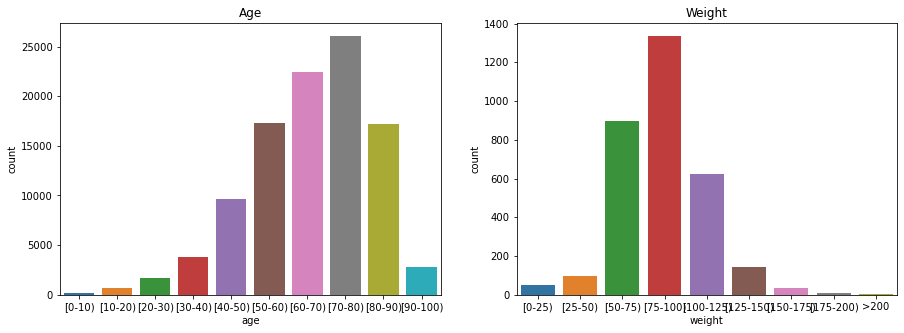

In [13]:
# distribution of age
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
ax = sns.countplot(x="age", data=df_eda,
                   order=['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)',
                          '[60-70)', '[70-80)', '[80-90)', '[90-100)'])
ax.set_title('Age')

# distribution of weight
plt.subplot(1,2,2)
ax = sns.countplot(x="weight", data=df_eda,
                   order=['[0-25)','[25-50)','[50-75)','[75-100)','[100-125)','[125-150)',
                          '[150-175)', '[175-200)', '>200'])
ax.set_title('Weight')
plt.show()

From the histograms below, we see that `num_lab_procedures` looks like Gaussian (however there's a second peak close to 0).

On the other hand, `number_outpatient`, `number_inpatient`, `number_emergency`, `number_diagnoses`, `num_medications`, and `num_procedures` are not Gaussian distrubuted.

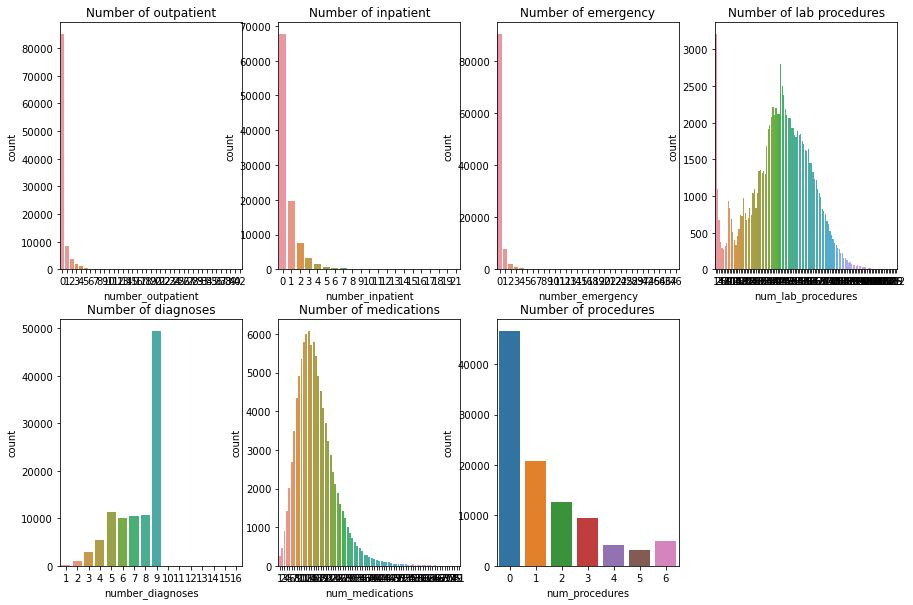

In [14]:
plt.figure(figsize=(15, 10))

# distribution of number_outpatient
plt.subplot(2,4,1)
ax = sns.countplot(x="number_outpatient", data=df_eda)
ax.set_title('Number of outpatient')

# distribution of number_inpatient
plt.subplot(2,4,2)
ax = sns.countplot(x="number_inpatient", data=df_eda)
ax.set_title('Number of inpatient')

# distribution of number_emergency
plt.subplot(2,4,3)
ax = sns.countplot(x="number_emergency", data=df_eda)
ax.set_title('Number of emergency')

# distribution of num_lab_procedures
plt.subplot(2,4,4)
ax = sns.countplot(x="num_lab_procedures", data=df_eda)
ax.set_title('Number of lab procedures')

# distribution of number_diagnoses
plt.subplot(2,4,5)
ax = sns.countplot(x="number_diagnoses", data=df_eda)
ax.set_title('Number of diagnoses')

# distribution of num_medications
plt.subplot(2,4,6)
ax = sns.countplot(x="num_medications", data=df_eda)
ax.set_title('Number of medications')

# distribution of num_procedures
plt.subplot(2,4,7)
ax = sns.countplot(x="num_procedures", data=df_eda)
ax.set_title('Number of procedures')
plt.show()

For `max_glu_serum`, `A1Cresult`, and `readmitted`, there are only 3 distinct categories for each.

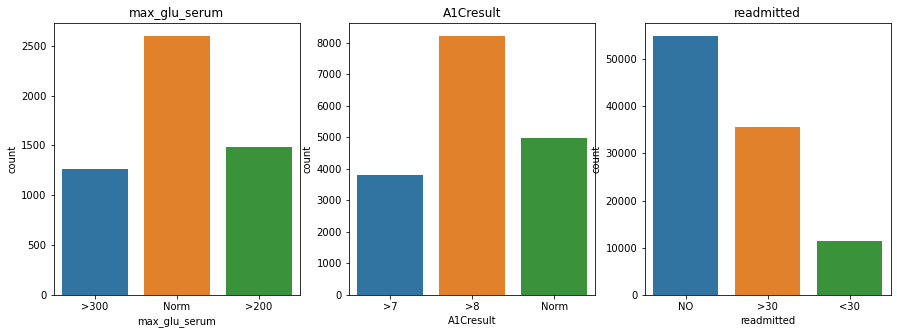

In [15]:
plt.figure(figsize=(15,5))

# distribution of max_glu_serum
plt.subplot(1,3,1)
ax = sns.countplot(x="max_glu_serum", data=df_eda)
ax.set_title('max_glu_serum')

# distribution of A1Cresult
plt.subplot(1,3,2)
ax = sns.countplot(x="A1Cresult", data=df_eda)
ax.set_title('A1Cresult')

# distribution of readmitted
plt.subplot(1,3,3)
ax = sns.countplot(x="readmitted", data=df_eda)
ax.set_title('readmitted')
plt.show()

Finally, the distribution of `time_in_hospital` (the value we want to predict) is not a Gaussian.

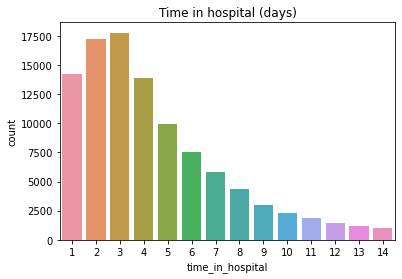

In [16]:
# distribution of time_in_hospital
ax = sns.countplot(x="time_in_hospital", data=df_eda)
ax.set_title('Time in hospital (days)')
plt.show()

# 3. Data Processing

After understanding the data, we need to perform some processing for the following feature extraction. We will:

1. Reduce the dimensionality of the NDC code (dims=251) to (dims=24)

2. Reduce the number of rows by only selecting the first encounter of each patient

3. Aggregate the dataframe by patient ID


## 3-1. Reduce Dimensionality of the NDC Code

The dimensionality of the NDC codes can be reduced because the same drug can be represented by multiple codes. This section uses the NDC drug lookup sheets https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv to find the generic drug name of each NDC code and stored it into a new column `generic_drug_name`.

Reference: https://ndclist.com/

In [17]:
# NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [18]:
print("Number of unique ndc_code: {}".format(df['ndc_code'].nunique()))
print("Number of unique non-proprietary names: {}".format(ndc_code_df['Non-proprietary Name'].nunique()))

Number of unique ndc_code: 251
Number of unique non-proprietary names: 24


In [19]:
# check if every ndc_code (except np.nan) exists in final_ndc_lookup_table
for x in df['ndc_code'].astype('str').unique():
    if x not in ndc_code_df['NDC_Code'].unique():
        print("{} is not in final_ndc_lookup_table".format(x))

nan is not in final_ndc_lookup_table


In [20]:
from student_utils import reduce_dimension_ndc

In [21]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [22]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [23]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,nan
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide


In [24]:
reduce_dim_df.shape

(143424, 27)

## 3-2. Select the First Encounter for Each Patient

For this project, we only use the data from the first encounter for each patient.

In [25]:
from student_utils import select_first_encounter

first_encounter_df = select_first_encounter(reduce_dim_df)

In [26]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


In [27]:
print(first_encounter_df.shape)

(101754, 27)


## 3-3. Aggregate Dataframe

In [28]:
# drop ndc_code
first_encounter_df = first_encounter_df.drop('ndc_code', axis=1)

In [29]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [30]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [31]:
# show the list of generic drugs
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide',
 'nan']

In [32]:
# inpect the data after aggregation
print(agg_drug_df.shape)
agg_drug_df.head()

(71518, 48)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,nan
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,"[Insulin Human, Glipizide]",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,"[Human Insulin, Rosiglitazone Maleate]",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,"[Glipizide, Human Insulin]",0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


The dataset is now ready for feature selection.

# 4. Feature Selection and Engineering


## 4-1. Feature Selection

Among all columns, `time_in_hospital` is the field we want to predict with our model.

The project requires we use `race`, `gender`, `age`, as well as `ndc_col_list` as features.

Regarding the remaining the columns, my heuristical decisions are:

- `encounter_id` won't be selected because for each patient, only the first encounter is used in the processed data.

- `patient_nbr` won't be selected because this is the unique patient ID.

- `weight` **won't be selected because there are too many (>96%) missing data.**. (see the cell below)

- `admission_type_id` won't be selected because this information could be contained in `admission_source_id`.

- `discharge_disposition_id` won't be selected. There'no much information in this columns. Plus the cadinality is too large. I want to start from a smaller model to see the performace before considering this column.

- `admission_source_id` will be selected as a **categorical feature**. It can be assumed that different sources of admission (Normal Delivery or Clinic Referral) can affect the time in the hospital.

- `payer_code` **won't be selected because the time spent in the hospital is not related to who is the health insurance company**.

- `medical_specialty` won't be selected because this information could be correlated with ndc drugs (ndc_col_list).

- `primary_diagnosis_code` won't be selected because this information could be correlated with ndc drugs (ndc_col_list).

- `other_diagnosis_codes` won't be selected because this information could be correlated with ndc drugs (ndc_col_list).

- `number_outpatient` won't be selected as a feature because for each patient, only the first encounter is used in the data.

- `number_inpatient` won't be selected as a feature because for each patient, only the first encounter is used in the data.

- `number_emergency` won't be selected because the number of previous emergency won't help a lot here.

- `num_lab_procedures` will be selected as a **numerical feature**.

- `number_diagnoses` won't be selected because this information could be learned from the ndc drugs (ndc_col_list).

- `num_medications` will be selected as a **numerical feature**.

- `num_procedures` won't be selected because this information could be correlated with `num_lab_procedures`

- `max_glu_serum` will be selected as a **categorical feature**.

- `A1Cresult` will be selected as a **categorical feature**.

- `change` won't be selected.

- `readmitted` won't be selected.

- `generic_drug_name_array` won't be selected because we already have ndc_col_list.

The decisions are heuristic. Due to the large number of columns we have, there're too many combinations to choose from.

ratio of missing values of weights = 0.960107944853044

Distribution of the availble weight data:


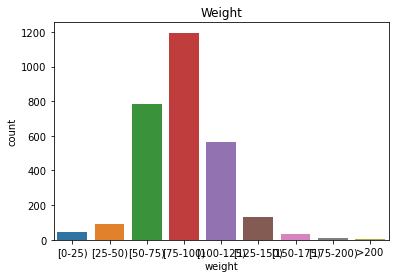

In [34]:
# analysis of the weight data
weights_data = agg_drug_df['weight'].tolist()
print("ratio of missing values of weights = {}".format(weights_data.count('?')/len(weights_data)))
print("\nDistribution of the availble weight data:")
ax = sns.countplot(x="weight", data=agg_drug_df,
                   order=['[0-25)','[25-50)','[50-75)','[75-100)','[100-125)','[125-150)',
                          '[150-175)', '[175-200)', '>200'])
ax.set_title('Weight')
plt.show()

In [35]:
# required columns (Udacity)
required_demo_col_list = ['race', 'gender', 'age']

# selected categorical columns (excluding ndc drugs)

student_categorical_col_list = ['admission_source_id', 'max_glu_serum', 'A1Cresult'] + required_demo_col_list + ndc_col_list

# selected numerical columns
student_numerical_col_list = ['num_medications', 'num_lab_procedures']

PREDICTOR_FIELD = 'time_in_hospital'

In [36]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list
    
    return agg_drug_df[selected_col_list]

In [37]:
selected_features_df = select_model_features(agg_drug_df,
                                             student_categorical_col_list,
                                             student_numerical_col_list,
                                             PREDICTOR_FIELD)

In [38]:
# see the dataframe with selected features
print(selected_features_df.shape)
selected_features_df.head()

(71518, 32)


,patient_nbr,time_in_hospital,admission_source_id,max_glu_serum,A1Cresult,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,nan,num_medications,num_lab_procedures
0,48330783,13,4,None,None,Caucasian,Female,[80-90),0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,68
1,63555939,12,4,None,None,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,18,33
2,42519267,1,7,None,None,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,51
3,89869032,9,7,None,None,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,17,47
4,82637451,3,2,None,None,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,16,31


## 4-2. Impute Numerical Features by Zeros

In [39]:
processed_df = preprocess_df(selected_features_df,
                             student_categorical_col_list,
                             student_numerical_col_list,
                             PREDICTOR_FIELD,
                             categorical_impute_value='nan',
                             numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## 4-3. Split Data

We split the data into 60% training dataset, 20% validation dataset, and 20% test dataset. After split, we confirm that there's not data leakage between the partitions.

In [40]:
from student_utils import patient_dataset_splitter

d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [41]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [42]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## 4-4. Demographic Representation Analysis of Split

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


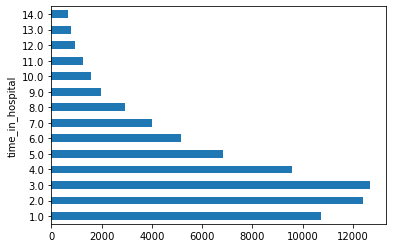

In [43]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6416
2.0     7403
3.0     7654
4.0     5761
5.0     4055
6.0     3094
7.0     2405
8.0     1797
9.0     1199
10.0     920
11.0     739
12.0     562
13.0     490
14.0     415
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


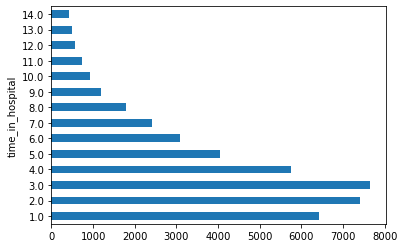

In [44]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2128
2.0     2517
3.0     2515
4.0     1941
5.0     1361
6.0     1055
7.0      789
8.0      559
9.0      391
10.0     329
11.0     259
12.0     175
13.0     149
14.0     136
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


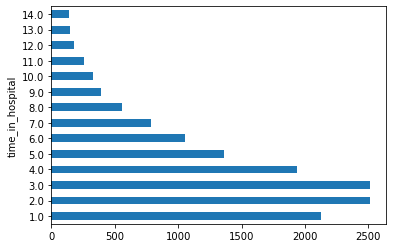

In [45]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


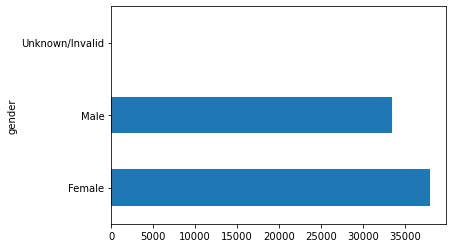

In [46]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22810
Male               20097
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


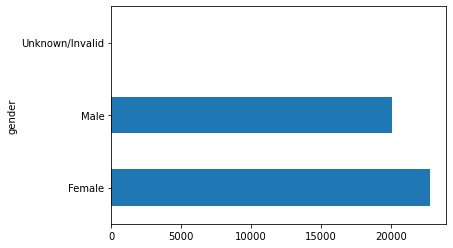

In [47]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7596
Male      6708
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


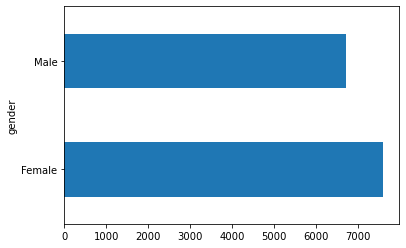

In [48]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## 4-5. Convert Dataset to TF Dataset

In [49]:
# convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [50]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

## 4-6. Create Categorical Features with TF Feature Columns

In [51]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [52]:
# view the list of vocab files
vocab_file_list

['./diabetes_vocab/admission_source_id_vocab.txt',
 './diabetes_vocab/max_glu_serum_vocab.txt',
 './diabetes_vocab/A1Cresult_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.txt',
 './diabetes_vocab/Pioglitazole_And_Metformin_Hydrochl

In [53]:
from student_utils import create_tf_categorical_feature_cols

tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 18 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the voc

In [54]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_source_id', vocabulary_file='./diabetes_vocab/admission_source_id_vocab.txt', vocabulary_size=18, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(128, 19), dtype=float32)


## 4-7. Create Numerical Features

In [55]:
for col in student_numerical_col_list:
    d_train[col] = d_train[col].astype('float32')
    d_val[col] = d_val[col].astype('float32')
    d_test[col] = d_test[col].astype('float32')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [56]:
import functools

from student_utils import normalize_numeric_with_zscore, create_tf_numeric_feature

In [57]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [58]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [59]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_medications', shape=(1,), default_value=(0.0,), dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fcce886f290>, mean=15.704707145690918, std=8.300407409667969))

tf.Tensor(
[[-0.875]
 [-1.375]
 [-0.125]
 [-0.25 ]
 [ 0.25 ]
 [-0.75 ]
 [-1.25 ]
 [ 1.   ]
 [-0.75 ]
 [-0.125]
 [-1.125]
 [ 1.25 ]
 [ 0.25 ]
 [-0.625]
 [ 1.625]
 [-0.75 ]
 [-0.125]
 [ 0.5  ]
 [ 0.375]
 [ 0.   ]
 [ 2.25 ]
 [ 0.5  ]
 [ 0.25 ]
 [ 0.   ]
 [ 0.25 ]
 [-0.625]
 [-0.625]
 [-0.5  ]
 [ 1.5  ]
 [-0.375]
 [ 0.125]
 [ 0.75 ]
 [-0.875]
 [ 0.375]
 [ 0.375]
 [-0.625]
 [-1.375]
 [-1.125]
 [-0.875]
 [ 0.375]
 [ 1.375]
 [-1.75 ]
 [-0.375]
 [ 0.625]
 [-0.5  ]
 [-0.5  ]
 [ 1.   ]
 [ 0.25 ]
 [-1.25 ]
 [-0.375]
 [ 0.   ]
 [ 0.25 ]
 [-0.625]
 [ 1.125]
 [-0.25 ]
 [-0.125]
 [-0.625]
 [-0.375]
 [ 1.25 ]
 [-0.75 ]
 [-0.875]
 [ 1.   ]
 [ 2.375]
 [ 1.375]
 [ 0.125]
 [-0.75 ]
 [-0.25 ]
 [ 0.125]
 [ 0.125]
 [-0.875]
 [ 0.75 ]
 [-1.25 ]
 [ 2.375]
 [

## 4-8. Combine Features with DenseFeatures

In [60]:
# concatenate categorical and numeric feature columns
claim_feature_columns = tf_cat_col_list + tf_cont_col_list

# combine with TF DenseFeatures
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

# 5. Build and Train the Model

The model is built with DenseFeatures and TF Probability Layers. The optimizer used is rmsprop. We train the model for 10 epochs.

In [61]:
def build_sequential_model(feature_layer):
    """
    Build model
    Args:
        feature_layer - feature layers created by TF DenseFeatures
    Output:
        model - the TF model
    """
    model = tf.keras.Sequential([feature_layer,
                                 tf.keras.layers.Dense(256, activation='relu'),
                                 tf.keras.layers.Dense(128, activation='relu'),
                                 tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
                                 tfp.layers.DistributionLambda(
                                     lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                                                       scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))])
    return model




def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    """
    Train the model
    Args:
        train_ds - the training dataset
        val_ds - the validation dataset
        feature_layer - feature layers created by TF DenseFeatures
        epochs - number of epochs (default=5)
        loss_metric - the loss function (default=MSE)
    Outputs:
        model - the trained model
        history - history of the metrics
    """
    # build the model
    model = build_sequential_model(feature_layer)
    
    # compile the model
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    
    # early stop callback
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)
    
    # train the model
    history = model.fit(train_ds, validation_data=val_ds, callbacks=[early_stop], epochs=epochs)
    
    return model, history 

In [62]:
# build and train the model
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 336 steps, validate for 112 steps
Epoch 1/10
336/336 [==============================] - 8s 23ms/step - loss: 26.8887 - mse: 26.7077 - val_loss: 21.4497 - val_mse: 20.9936
Epoch 2/10
336/336 [==============================] - 4s 13ms/step - loss: 17.6085 - mse: 16.8582 - val_loss: 14.7957 - val_mse: 13.8172
Epoch 3/10
336/336 [==============================] - 4s 13ms/step - loss: 14.2939 - mse: 13.2692 - val_loss: 12.6804 - val_mse: 11.4696
Epoch 4/10
336/336 [==============================] - 4s 13ms/step - loss: 13.0862 - mse: 11.9499 - val_loss: 12.8129 - val_mse: 11.7550
Epoch 5/10
336/336 [==============================] - 4s 13ms/step - loss: 12.0646 - mse: 10.8102 - val_loss: 11.2081 - val_mse: 9.9454
Epoch 6/10
336/336 [==============================] - 5s 13ms/step - loss: 11.4048 - mse: 10.0658 - val_loss: 11.6736 - val_mse: 10.6088
Epoch 7/10
336/336 [==============================] - 5s 13ms/step - loss: 10.7649 - mse: 9.5348 - val_loss: 10.2402 - val_mse: 9.0445


# 6. Results

## 6-1. Uncertainty of Model Prediction

We use TF Probability Layer to build the model. As a result, we can extract the mean and standard deviation for each prediction the model made.

In [63]:
# list of columns used as features
feature_list = student_categorical_col_list + student_numerical_col_list
# 
diabetes_x_tst = dict(d_test[feature_list])
# 
diabetes_yhat = diabetes_model(diabetes_x_tst)

# predict on the test dataset
preds = diabetes_model.predict(diabetes_test_ds)

In [64]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

In [65]:
# create a dict for building the dataframe
prob_outputs = {"pred": preds.flatten(),
                "actual_value": d_test['time_in_hospital'].values,
                "pred_mean": m.numpy().flatten(),
                "pred_std": s.numpy().flatten()}

# convert prob_outputs into a dataframe
prob_output_df = pd.DataFrame(prob_outputs)

In [66]:
# check the results
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,2.008657,13.0,6.858282,0.692678
1,1.771225,3.0,2.649667,0.694800
2,3.075974,2.0,2.677132,0.693881
3,2.216135,5.0,4.751198,0.694330
4,0.891679,6.0,5.061519,0.694689


## 6-2. Patient Selection

We use the mean of the prediction to perform binary classification on each patients.

In [67]:
from student_utils import get_student_binary_prediction

student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

In [68]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    """
    Create a dataframe for the test dataset with 'score' and 'label_value'.
    'score' is the binary prediction that a patient would spend >= 5 days in the hospital
    'label_value' is the ground truth that a patient spent >= 5 days in the hospital
    Args:
        test_df - the test dataset
        pred_np - the binary prediction of the test dataset by the model
        demo_col_list: the categorical feature names
    Output:
        test_df - dataframe of the test dataset (with score and label_value)
    """
    
    # convert all values of the categorical columns into strings
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    
    # model binary prediction
    test_df['score'] = pred_np
    
    # acutal labels
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    
    return test_df


pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [69]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,48330783,Female,Caucasian,13.0,1,1
4,82637451,Male,Caucasian,3.0,0,0
11,86047875,Female,AfricanAmerican,2.0,0,0
15,107389323,Male,AfricanAmerican,5.0,0,1
16,69422211,Male,?,6.0,1,1


# 7. Model Evaluation

## 7-1. Precision and Recall

Precision is the ratio of the number of true positives to the sum of the true positives and false positives. Recall is the ratio of the number of true positives to the sum of the true positives and false negatives. There's a tradeoff between them. If we increase the precision (we say no to the data that we're less confident in classifying as positive), we will classfy more true positives as negative and as a result decreasing the recall. On the other hand, if we increase the recall (by saying yes to the data that we're less confident in classifying it as as negative), we will calssify more true negative data as positive and as a result decreasing the precision.

In this project, I think precision is more important than recall because testing our drugs on the false positives data, i.e., a patient who is not going to stay in the hostipal for more than 5 days, are pricy.

For future improvement, I'd like to try to increase the recall without sacrificing the precision too much. I'll tune the parameters of the model such as the number of hidden layers and hidden units. Use some regularization method such as dropout layers, to see how the model performs. I can also try different feature selections.

In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

y_true = pred_test_df['label_value']
y_pred = pred_test_df['score']

# AUC, F1, precision and recall
# Summary

auc = roc_auc_score(y_true, y_pred)
print("AUC = {:.4f}\n".format(auc))

f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score = {:.4f}\n".format(f1))

precision = precision_score(y_true, y_pred)
print("Precision = {:.4f}\n".format(precision))

recall = recall_score(y_true, y_pred)
print("Recall = {:.4f}\n".format(recall))

AUC = 0.5861

F1 score = 0.6243

Precision = 0.8585

Recall = 0.1901



My model has a small recall, but it has a high precision.

## 7-2. Biases

We use [Aequitas](https://github.com/dssg/aequitas) to analyze the biases of the model.

In [71]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness


ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)

g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)

aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [1152]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


In [72]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                                        original_df=ae_df, 
                                        ref_groups_dict={'race':'Caucasian', 'gender':'Male'}, 
                                        alpha=0.05, 
                                        check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


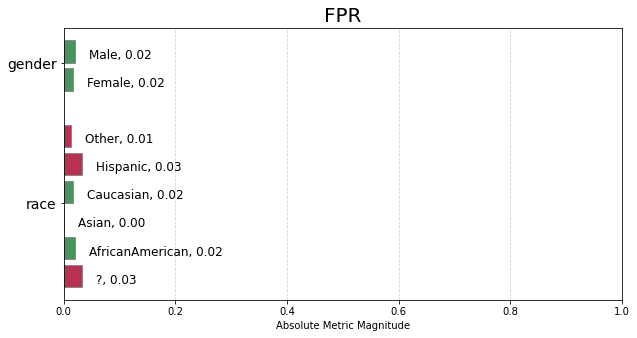

In [74]:
# fairness: false positive rate
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

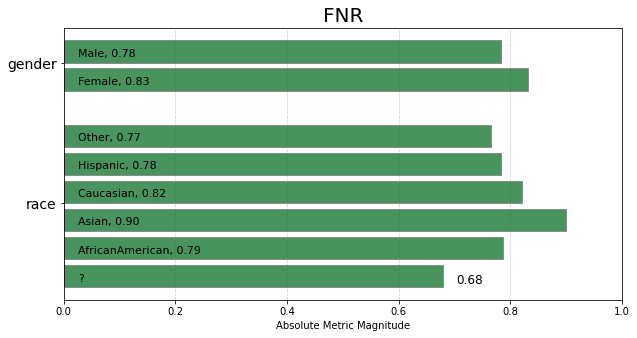

In [75]:
# fairness: false negative rate
fnr_fairness = aqp.plot_fairness_group(fdf, group_metric='fnr', title=True)

## 7-3. Disparity

From the figures below we see that compared to Caucasian (the reference group), all other races have a higher false positive rate.

On the other hand, we don't see this in gender. Gender doesn't not have much influence on the false positive rate.

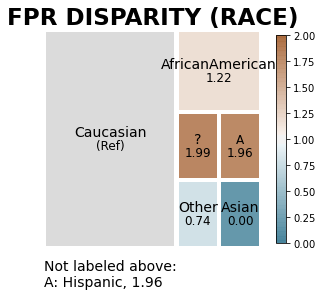

In [76]:
# FPR disparity of race
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

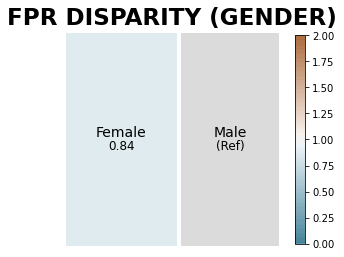

In [77]:
# FPR disparity of gender
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender')